### Imports

In [1]:
from PIL import Image
import os
import os.path as osp
import sys
sys.path.insert(0, '..')

import numpy as np
import matplotlib.pyplot as plt
import skimage

%load_ext autoreload
%autoreload 2

We will be using a simple unsupervised retinal vessel segmentation technique to build some preliminary solutions. I have coded it up and stored it in the `utils` folder.

In [2]:
from utils.unsupervised_vessel_seg import find_vessels_unsupervised as f_v

### Paths

In [3]:
path_to_data = '../data/DRIVE/test/'
path_to_ims = osp.join(path_to_data, 'images')
path_to_masks = osp.join(path_to_data, 'mask')
path_to_gt = osp.join(path_to_data, '1st_manual')

In [4]:
im_list = os.listdir(path_to_ims)

im_names = [osp.join(path_to_ims, name) for name in im_list]
mask_names = [osp.join(path_to_masks, name[:-4]+'_mask.gif') for name in im_list]
gt_names = [osp.join(path_to_gt, name[:2]+'_manual1.gif') for name in im_list]

In [5]:
image = Image.open(im_names[0])
mask = Image.open(mask_names[0])
gt = Image.open(gt_names[0])

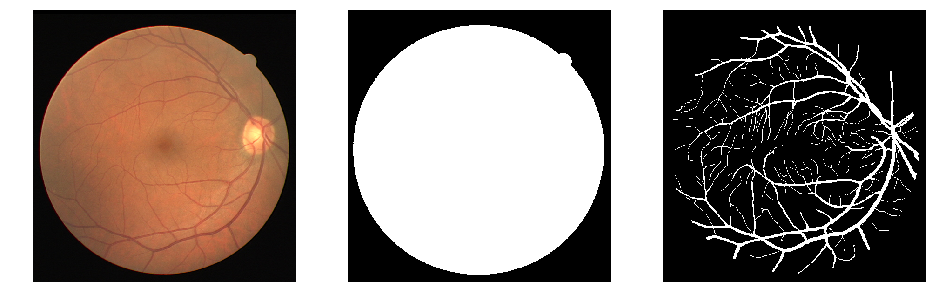

In [6]:
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(16,12))
ax[0].imshow(image), ax[0].axis('off')
ax[1].imshow(mask, cmap='gray'), ax[1].axis('off')
ax[2].imshow(gt, cmap='gray'), ax[2].axis('off')
plt.show()

Let us build a solution for this image:

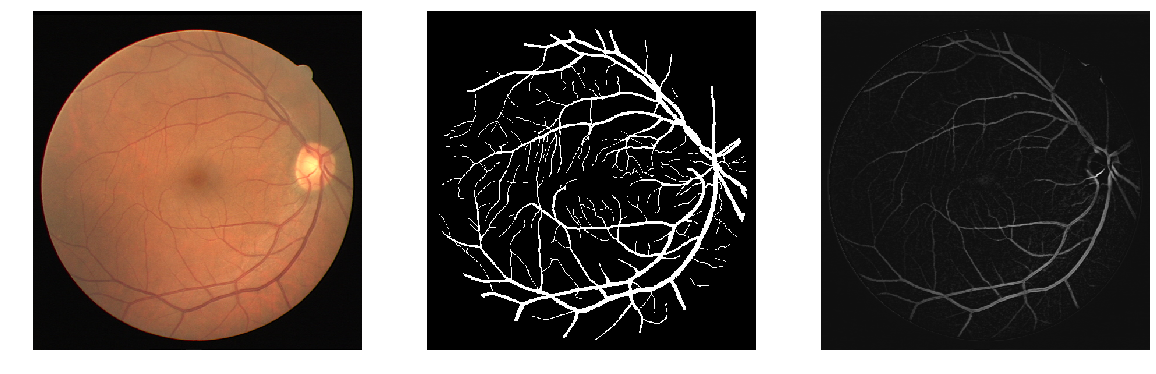

In [7]:
solution = f_v(image)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,12))
ax[0].imshow(image), ax[0].axis('off')
ax[1].imshow(gt, cmap='gray'), ax[1].axis('off')
ax[2].imshow(solution, cmap='gray'), ax[2].axis('off')
plt.show()

First, let us cast the gt to a `numpy` boolean array:

In [8]:
gt = np.array(gt).astype(bool)

### Optimal thresholding

You now have a grayscale image, and for each pixel you have there the likelihood of such pixel being part of a retinal vessel. This is similar to what you will get out of your UNET. Now, in order to obtain a binary image that represents a final solution, you need to threshold/binarize this grayscale image. What is a good threshold for it? The answer is, it depends. For instance, we might be interested in maximizing accuracy. Imagine you threshold the solution at `t=0.085`:

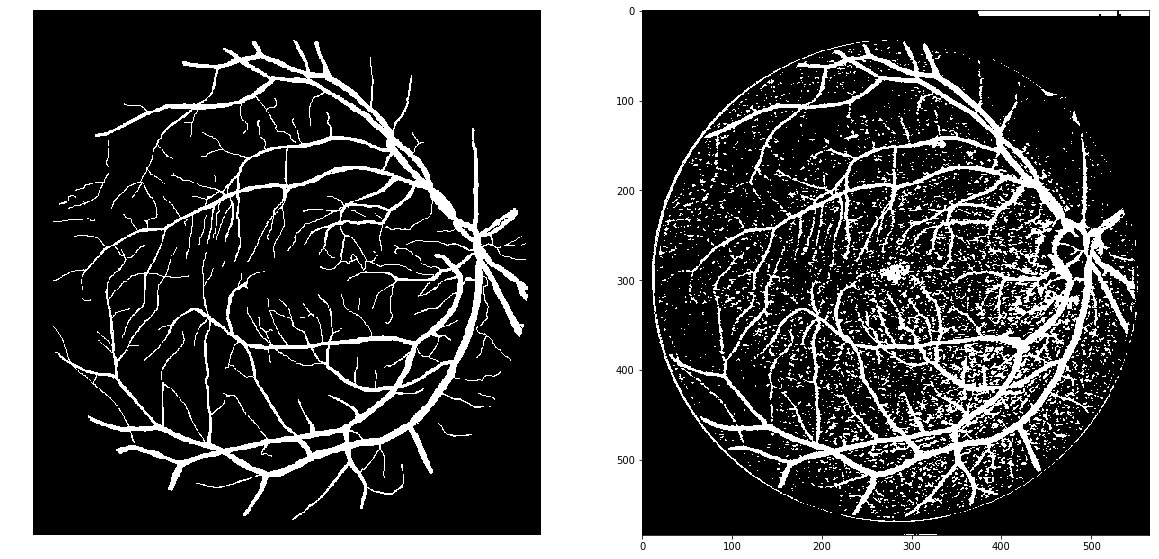

In [9]:
sol = solution>0.085
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
ax[0].imshow(gt, cmap='gray'), ax[0].axis('off')
ax[1].imshow(sol, cmap='gray'), ax[0].axis('off')
plt.show()

Ok, this is not a very good decision, but at least all major vessels seem to be there. Now, we can now compute the accuracy of this solution using `sklearn`. For this we first need to "unroll" the truth values and the corresponding predictions into a 1-dimensional vector:

In [10]:
gt_flat = np.ravel(gt)
sol_flat = np.ravel(sol)

Now we can compute accuracy:

In [11]:
from sklearn.metrics import accuracy_score

In [12]:
accuracy_score(gt_flat, sol_flat)

0.8868953812583343

### **Question**
Use threshold `t=0.50` to compute accuracy:

In [13]:
# your code here

In [14]:
sol = solution>0.50
gt_flat = np.ravel(gt)
sol_flat = np.ravel(sol)
accuracy_score(gt_flat, sol_flat)

0.9031003758031276

According to this metric, this second solution seems to be better. Now plot the solution thresholded at `t=0.50`, and think about which of both solutions you would prefer:

In [15]:
# your code here

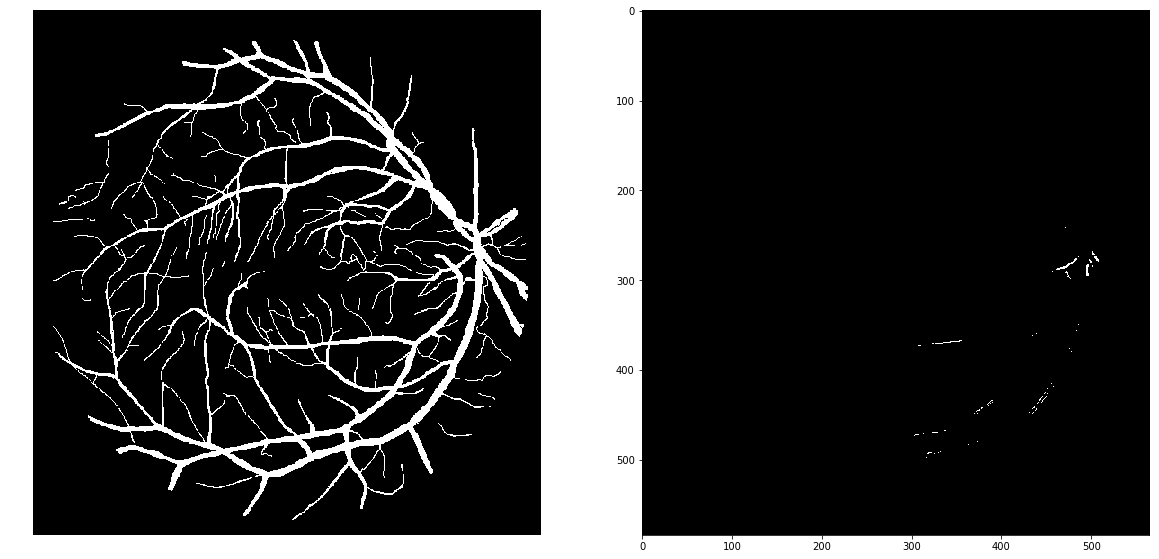

In [16]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
ax[0].imshow(gt, cmap='gray'), ax[0].axis('off')
ax[1].imshow(sol, cmap='gray'), ax[0].axis('off')
plt.show()

As you see, accuracy in this case is a misleading metric, due to the problem being highly imbalanced. Let us try a more meaningful metric, the f1-score:

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html#sklearn.metrics.f1_score

In [17]:
from sklearn.metrics import f1_score

In [18]:
sol_12 = solution>0.085
sol_50 = solution>0.50

In [19]:
sol_12_flat = np.ravel(sol_12)
sol_50_flat = np.ravel(sol_50)
f1_score(gt_flat, sol_12_flat), f1_score(gt_flat, sol_50_flat)

(0.5950432952103996, 0.017636034043076166)

### **Question**
Write a for loop that thresholds the image at different levels and computes the accuracy and f1scores for each of the results. Build an array called `performance_array` with three columns. In each row store a threshold and the corresponding two metrics (accuracy, f1d). For the thresholds over which you want to loop, use the following:

In [23]:
thresholds = np.linspace(0, 1, 200, endpoint=False)

In [24]:
# your code here -- reduce the number of thresholds (200) if you want faster computations

In [25]:
performance_array = np.zeros([len(thresholds), 3])

In [26]:
gt_flat = np.ravel(gt)
for i in range(len(thresholds)):
    t = thresholds[i]
    performance_array[i,0] = t
    
    sol = solution>t
    sol_flat = np.ravel(sol)
    
    performance_array[i,1] = accuracy_score(gt_flat, sol_flat)
    performance_array[i,2] = f1_score(gt_flat, sol_flat)

### **Question**
Find the row that contains the maximum accuracy and the row that contains the maximum f1 score. Use the corresponding thresholding value to build the solution that maximizes each quantity. Hint: use `np.argmax` across rows (`axis=0`).

In [28]:
# your code here

In [29]:
np.argmax(performance_array, axis=0)[1:] # disregard first column, obviously max value is last value

array([25, 23])

Note that even if accuracy is not a good metric to compare to "bad solutions", it still identify which is the best solution in a meaningful way. Let us plot each metric against the threshold employed:

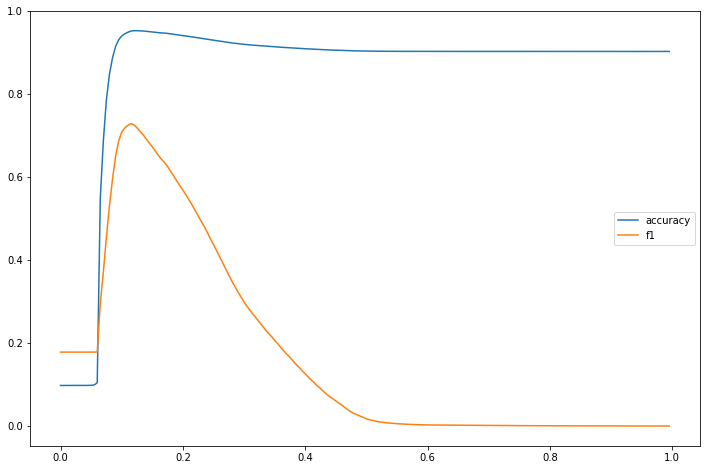

In [30]:
plt.figure(figsize=(12,8))
plt.plot(performance_array[:,0], performance_array[:,1], label='accuracy')
plt.plot(performance_array[:,0], performance_array[:,2], label='f1')
plt.legend(loc='center right')
plt.show()

Let us plot the optimal solution:

In [33]:
opt_t = performance_array[25, 0] # 25 was the index of the optimal threshold computed above for accuracy
opt_sol = solution>opt_t
print('The optimal threshold was ', opt_t)

The optimal threshold was  0.125


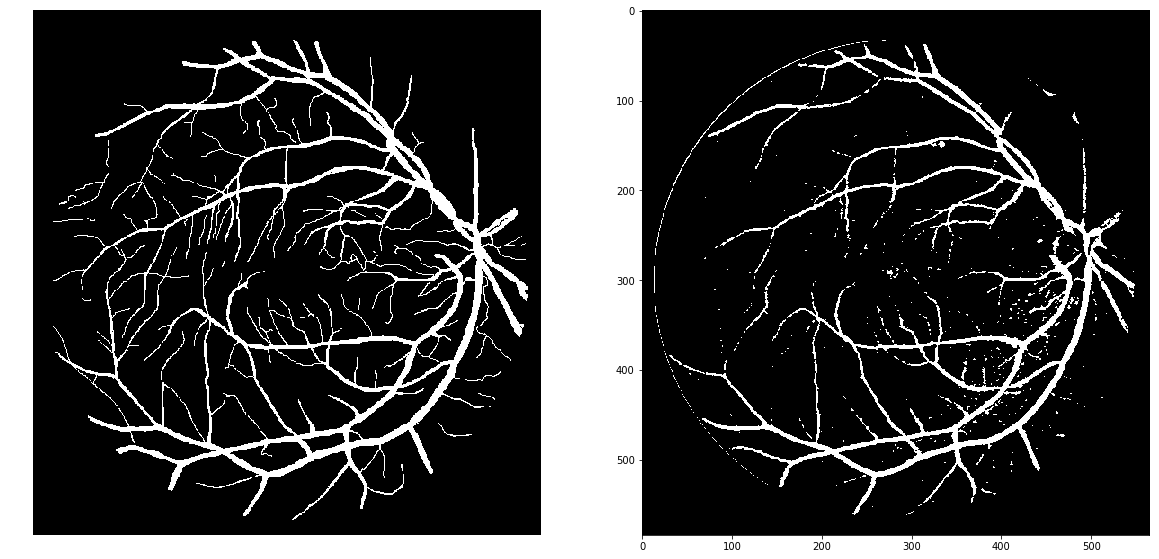

In [32]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,12))
ax[0].imshow(gt, cmap='gray'), ax[0].axis('off')
ax[1].imshow(opt_sol, cmap='gray'), ax[0].axis('off')
plt.show()

### **Question**
As we just saw above the optimal threshold maximizing the accuracy for this particular image is `0.125`. Find the threshold that maximizes the accuracy for the second image in the dataset. 

For this you first need to build the solution corresponding to that image, load its ground-truth, and repeat part of the above analysis:

In [34]:
image = Image.open(im_names[1])
mask = Image.open(mask_names[1])
gt = Image.open(gt_names[1])

gt = np.array(gt).astype(bool)

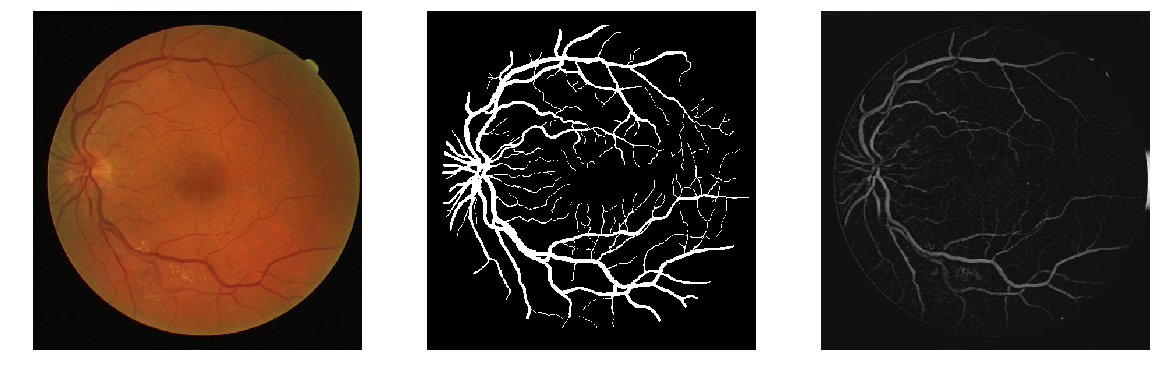

In [35]:
solution = f_v(image)

f, ax = plt.subplots(nrows=1, ncols=3, figsize=(20,12))
ax[0].imshow(image), ax[0].axis('off')
ax[1].imshow(gt, cmap='gray'), ax[1].axis('off')
ax[2].imshow(solution, cmap='gray'), ax[2].axis('off')
plt.show()

Now it is your turn:

In [36]:
# your code here

In [37]:
thresholds = np.linspace(0, 1, 200, endpoint=False) # again, decrease from 200 if you find it too heavy
performance_array = np.zeros([len(thresholds), 2])

gt_flat = np.ravel(gt)
for i in range(len(thresholds)):
    t = thresholds[i]
    performance_array[i,0] = t
    
    sol = solution>t
    sol_flat = np.ravel(sol)
    
    performance_array[i,1] = accuracy_score(gt_flat, sol_flat)

In [39]:
opt_threshold_idx = np.argmax(performance_array, axis=0)[1]
opt_t = thresholds[opt_threshold_idx] 
print('The optimal threshold was ', opt_t)

The optimal threshold was  0.13


### Important Reflection
As you see, the optimal threshold for each image is slightly different. Now imagine you send your shiny working 
model to a clinical scenario where they need binary solutions, and they ask you about the threshold they should be applying for your grayscale predictions. You cannot tell them that for each image they should repeat the above process to find out which one is the optimal threshold. **Why?** 

It is very important that you understand the answer to this question. In clinical practice, they do not have a ground-truth solution, as they want to use your model to build segmentations from images without having to hand-label anything. Therefore there is no access to a ground-truth. For this reason, you need to find a way to give them a single number to apply for each image. This error can be found even in recent research papers, like here:

https://www.sciencedirect.com/science/article/pii/S0169260716309002

(see table 3). Anyway, the correct thing to do is to accumulate all predictions and ground-truths in a single (very large) array, and only then compute an optimal threshold. Let me illustrate that for you:

Let us rebuild the solutions for the first and second images

In [40]:
image0 = Image.open(im_names[0])
mask0 = Image.open(mask_names[0])
gt0 = Image.open(gt_names[0])

gt0 = np.array(gt0).astype(bool)

solution0 = f_v(image0)

image1 = Image.open(im_names[1])
mask1 = Image.open(mask_names[1])
gt1 = Image.open(gt_names[1])

gt1 = np.array(gt1).astype(bool)

solution1 = f_v(image1)

Now we build a compounded predictions and gt values array, before repeating the above performance analysis:

In [41]:
gt_flat_0 = np.ravel(gt0)
gt_flat_1 = np.ravel(gt1)
gt_flat_composed = np.hstack([gt_flat_0, gt_flat_1])

In [42]:
gt_flat_0.shape, gt_flat_1.shape, gt_flat_composed.shape

((329960,), (329960,), (659920,))

In [43]:
solution_flat_0 = np.ravel(solution0)
solution_flat_1 = np.ravel(solution1)
solution_flat_composed = np.hstack([solution_flat_0, solution_flat_1])

With this, we just need to do as above but now with the expanded arrays:

In [45]:
thresholds = np.linspace(0, 1, 200, endpoint=False)
performance_array = np.zeros([len(thresholds), 2])

for i in range(len(thresholds)):
    t = thresholds[i]
    performance_array[i,0] = t
    
    sol = solution_flat_composed>t
    performance_array[i,1] = accuracy_score(gt_flat_composed, sol)

In [46]:
opt_threshold_idx = np.argmax(performance_array, axis=0)[1]
opt_t = thresholds[opt_threshold_idx] 
print('The optimal threshold was ', opt_t)

The optimal threshold was  0.125


## Other metrics:
Typical metrics reported in medical papers are sensitivity and specificity, which can also be computed for segmentation tasks. Both quantities rely on the notion of False Positive, False Negative, True Positive, and True Negative.

First google the meaning of both terms, and then observe how they can be computed from the confusion matrix (google also this one if you are not familiar with it).

In [47]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(gt.ravel(), opt_sol.ravel()).ravel()

In [48]:
specificity = tn/(tn+fp)
sensitivity = tp/(tp+fn)
print(specificity, sensitivity)

0.9308034887752594 0.09591706442100142


## The non-binary case
There exist metrics that do not require you to specify a threshold, but rather look at how good your model is in the entire range of possible thresholds. For instance, in order to build an ROC curve, you use you "grayscale" predictions. The ROC curve is composed by looping on lots of possible thresholds and plotting (1-specificty) - also known as False Positive Rate or FPR - against sensitivity - also known as True Positive Rate or TPR:

In [49]:
from sklearn.metrics import roc_curve, roc_auc_score
fpr, tpr, thresholds = roc_curve(gt.ravel(), solution.ravel())

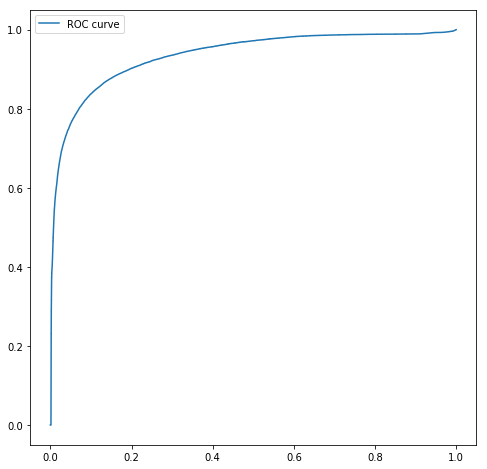

In [50]:
plt.figure(figsize=(8,8))
plt.plot(fpr, tpr, label='ROC curve')
plt.legend()
plt.show()

The area under the ROC curve is a good summary of the performance of the model with a single number:

In [51]:
roc_auc_score(gt.ravel(), solution.ravel())

0.9352385253998583

With this, we can for instance find the threshold that maximizes the quantity TPR-FPR, also known as **Youden index**:

In [52]:
thresholds[np.argmax(tpr - fpr)]

0.09268549535432241

## Homework 1
Maybe you noticed that we are all the time loading the circular mask around the retina, but we never use it? The truth is, what we typically want to do is disregard every pixel that is not inside this mask (called Field of View mask, or FOV), since they are trivial to predict (always non-vessel). The correct way of doing all the above is to mask out pixels outside the FOV. For that, you would do sth like this:

In [57]:
image0 = Image.open(im_names[0])
mask0 = Image.open(mask_names[0])
gt0 = Image.open(gt_names[0])

gt0 = np.array(gt0).astype(bool)
mask0 = np.array(mask0).astype(bool)

solution0 = f_v(image0)

First consider accuracy computation with all pixels, as we have been doing all the time above:

In [64]:
gt0_flat = gt0.ravel()
mask0_flat = mask0.ravel()
solution0_flat = solution0.ravel()
print('Nr of considered pixels:', gt0_flat.shape[0])
acc = accuracy_score(gt0_flat, solution0_flat>0.125)
print('Accuracy for this image:', acc)

Nr of considered pixels: 329960
Accuracy for this image: 0.9522366347436053


Now, this is what you want to do to remove "uninteresting pixels":

In [66]:
noFOV_gt0 = gt0_flat[mask0_flat==True]
noFOV_solution0 = solution0_flat[mask0_flat==True]
print('Nr of considered pixels:', noFOV_gt0.shape[0])
acc = accuracy_score(noFOV_gt0, noFOV_solution0>0.125)
print('Accuracy for this image when considering only FOV pixels:', acc)

Nr of considered pixels: 227500
Accuracy for this image when considering only FOV pixels: 0.9309626373626374


As you see, accuracy is lower when you disregard trivial pixels. Repeat the Performance Analysis on the DRIVE dataset, but this time not considering pixels out of the FOV for performance computation. Are the optimal thresholds similar now?

## Homework 2
Compute the area under the ROC curve and the threshold maximizing the Youden index, not for a single image but for the entire dataset. You will need to accumulate predictions and ground-truths in a single, very big array, before computing the ROC (which may take quite a bit of time even in a decent computer). Do this by also disregarding all pixels outside the corresponding FOVs.